Importowane biblioteki i pliki:

In [514]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

titanic_df = pd.read_csv('titanic.csv', index_col='PassengerId')

Podstawowa analiza:

In [515]:
print(titanic_df.shape)


(891, 11)


In [516]:
titanic_df.head(4)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


In [517]:
titanic_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,793.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,33.123938
std,0.486592,0.836071,14.526497,1.102743,0.806057,51.578312
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.925000
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.500000
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Informacje o ilości niepustych wartości oraz typów kolumn

In [518]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      793 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


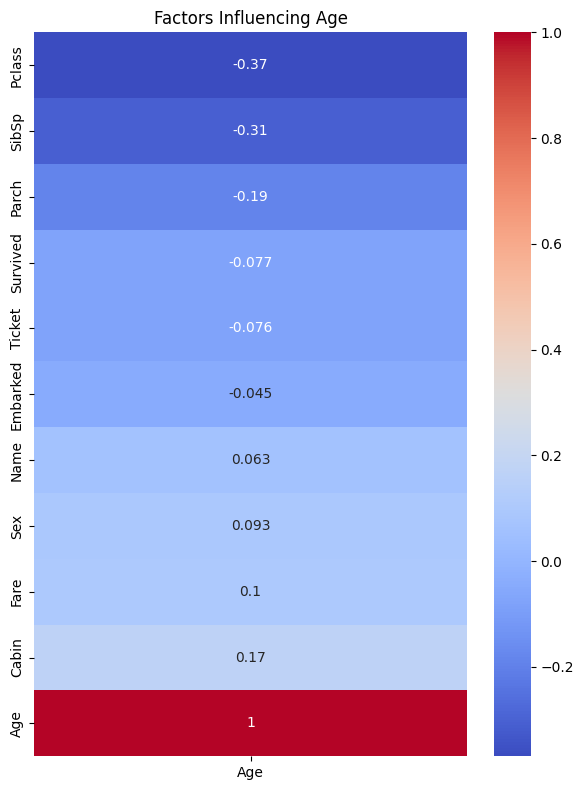

In [519]:
df_encoded = titanic_df.copy()

for col in df_encoded.select_dtypes(include=['object', 'category']).columns:
  df_encoded[col] = df_encoded[col].astype('category').cat.codes

corr = df_encoded.corr()

plt.figure(figsize=(6, 8))
sns.heatmap(corr[['Age']].sort_values(by='Age'),annot=True, cmap='coolwarm')
plt.title('Factors Influencing Age')
plt.tight_layout()
plt.show()

**Czyszczenie i Modyfikacja Danych**

Kolumny w których może brakować danych to: Age, Fare, Cabin oraz Embarked.

*   Age - Uzupełnienie będzie mediana na podstawie grup kategorii Cabin i Sex, które według heatmapy miały największy wpływ na kolumnę Age z wartości kategorialnych. Dodatkowo wartości Age zostaną najpierw zaokrąglone w górę do pełnych lat, żeby dokładność mierzonego wieku była wszędzie jednakowa.
*   Fare - Zostanie uzupełnione jako średnia na podstawie klasy klienta oraz portu z którego ta osoby wypłyneła.
*   Cabin - Kolumna zostanie wykorzystana do stworzenia nowej CGroup złożonej jedynie z litery kabiny. W przypadku braku informacji zostanie przypisana wartość U.
*   Embarked - Tylko w dwóch przypadkach brakuje informacji. Zostanie ona uzupełniona przez najczęstszą kategorie występującą w tej kolumnie.

Kolumny, które zdecydowałem się usunąć to:


*   Name - Brak znaczących danych do wyciągnięcia
*   Ticket - Na jego podstawie powstanie kolumna TPref zawierająca dane True/False (1/0) oznaczające czy dany bilet posiadał Prefiks.
*   Cabin - Dane zostaną wykorzystane do stworzenia dodatkowej kolumny.

Dodatkowo zdecydowałem się stworzyć kolumnę isAlone, która przyjmie wartości True/False (1/0) w zależności od tego czy pasażer podróżował bez rodziny.



In [520]:
titanic_df = titanic_df.drop("Name",axis=1)

titanic_df['Embarked'] = titanic_df['Embarked'].fillna(titanic_df['Embarked'].mode()[0])

titanic_df['Fare'] = titanic_df.groupby(['Pclass', 'Embarked'])['Fare'].transform(lambda s: s.fillna(s.mean()).round(4).astype('float64'))

titanic_df['Cabin'] = titanic_df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'U')
titanic_df.rename({'Cabin':'CGroup'},axis=1, inplace=True)

titanic_df['Age'] = titanic_df['Age'].round(0).astype('float64')
titanic_df['Age'] = titanic_df.groupby(['CGroup', 'Sex'])['Age'].transform(lambda x: x.fillna(x.median()))
titanic_df['Age'] = titanic_df['Age'].astype(int)

titanic_df['Ticket'] = titanic_df['Ticket'].apply(lambda x: 1 if " " in x else 0)
titanic_df.rename({'Ticket':'TPref'},axis=1, inplace=True)


titanic_df['isAlone'] = titanic_df.apply(lambda x: 0 if (x['SibSp'] + x['Parch'])>0 else 1,axis=1)

titanic_df['Sex'] = titanic_df['Sex'].apply(lambda x: 1 if x=='male' else 0)
titanic_df.rename({'Sex':'isMale'},axis=1, inplace=True)

In [521]:
titanic_df.info()
titanic_df.loc[:]

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   isMale    891 non-null    int64  
 3   Age       891 non-null    int64  
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   TPref     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   CGroup    891 non-null    object 
 9   Embarked  891 non-null    object 
 10  isAlone   891 non-null    int64  
dtypes: float64(1), int64(8), object(2)
memory usage: 83.5+ KB


,Survived,Pclass,isMale,Age,SibSp,Parch,TPref,Fare,CGroup,Embarked,isAlone
PassengerId,,,,,,,,,,,
1,0,3,1,22,1,0,1,7.2500,U,S,0
2,1,1,0,38,1,0,1,71.2833,C,C,0
3,1,3,0,26,0,0,1,7.9250,U,S,1
4,1,1,0,35,1,0,0,53.1000,C,S,0
5,0,3,1,35,0,0,0,8.0500,U,S,1
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,1,27,0,0,0,13.0000,U,S,1
888,1,1,0,19,0,0,0,30.0000,B,S,1
889,0,3,0,25,1,2,1,23.4500,U,S,0


Zdecydowałem się usunąć kolumny

In [522]:
def plot_categorical_data_perc(df, column,target=None):
  plt.figure(figsize=(8, 4))
  sns.histplot(data=titanic_df,x=column,hue=target,stat='percent',multiple='fill')
  plt.show()

def plot_categorical_data_count(df, column, target=None):
  plt.figure(figsize=(8, 4))
  sns.countplot(data=df, x=column, hue=target)
  plt.title(f"Dystrybucja {column} względem {target}")
  plt.show()

def plot_numerical_data(df, column,target=None):
  plt.figure(figsize=(8, 4))
  sns.kdeplot(data=titanic_df,x=column,hue=target)
  plt.tight_layout()
  plt.title(f"Dystrybucja {column} względem {target}")
  plt.show()

In [523]:
numerical_columns = ['Age','Fare','SibSp','Parch']
categorical_columns = ['Pclass','isMale','TPref','CGroup','Embarked','isAlone']

Rozkłady wartości numerycznych względem przeżywalności

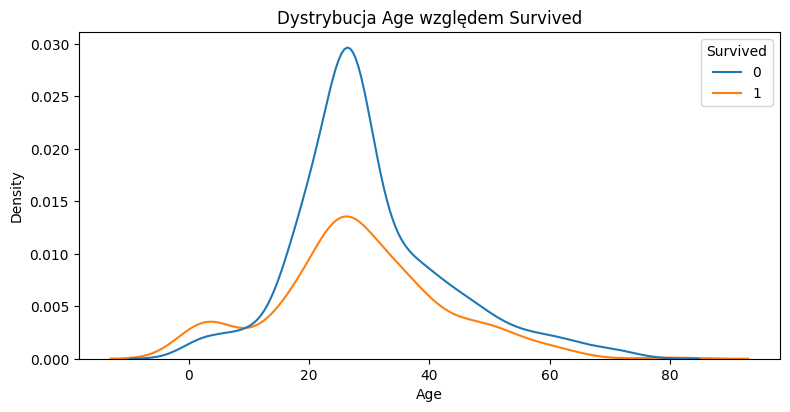

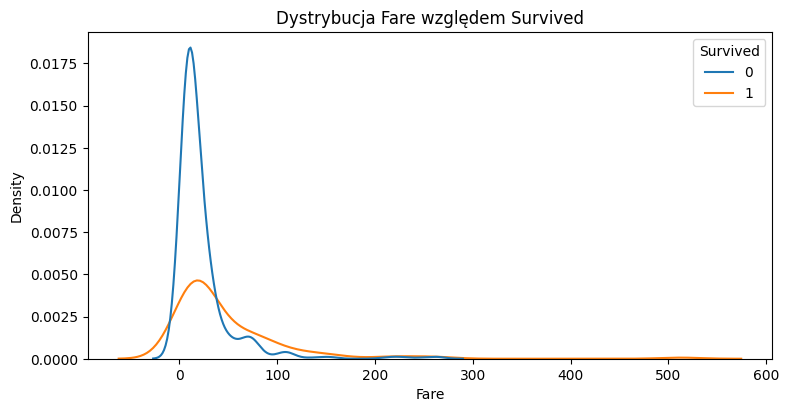

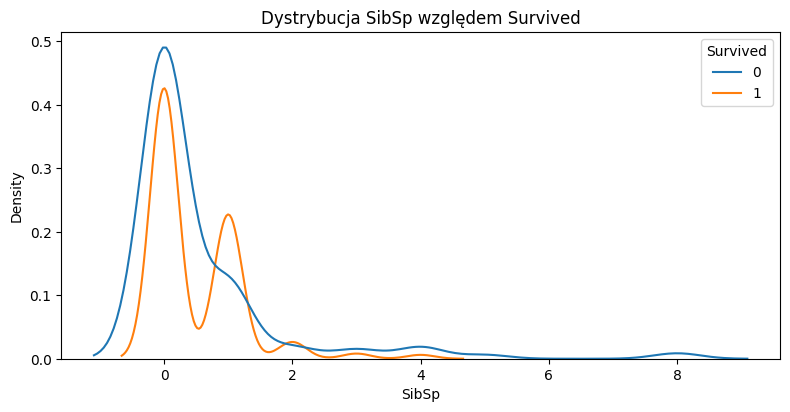

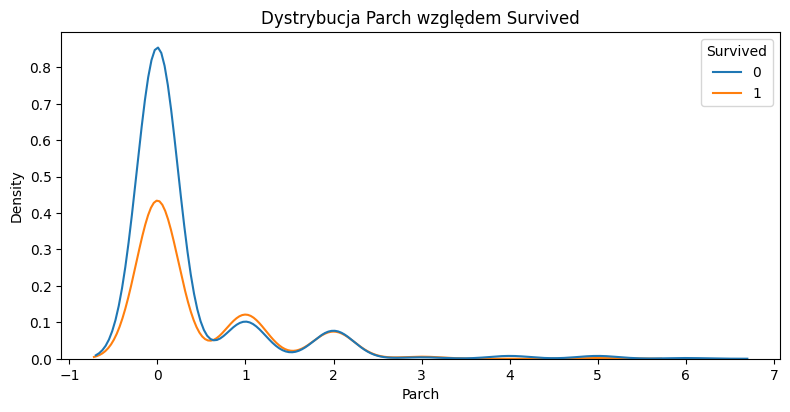

In [524]:
for col in numerical_columns:
  plot_numerical_data(titanic_df,col,target='Survived')

Rozkłady wartości kategorialnych względem przeżywalności (Liczbowa oraz procentowa)

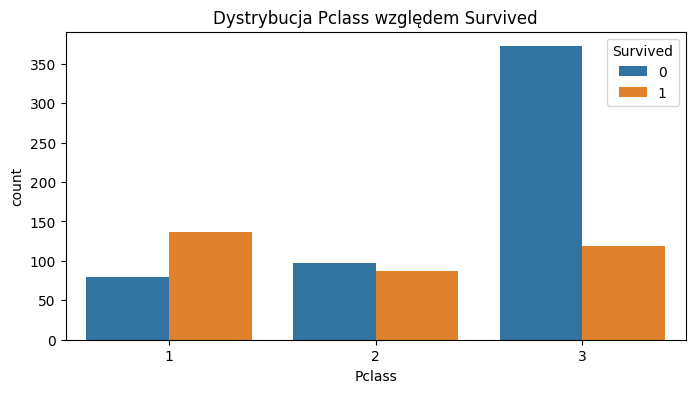

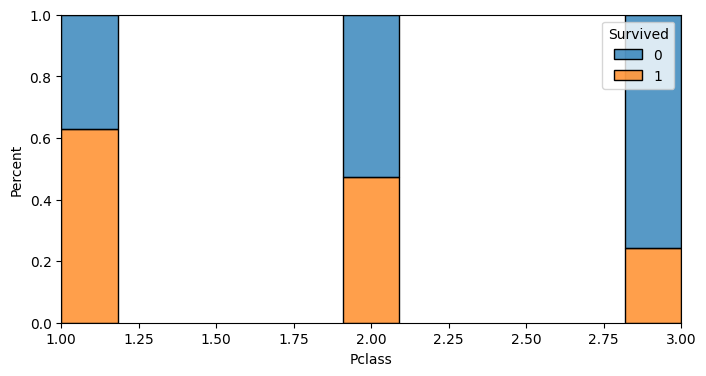

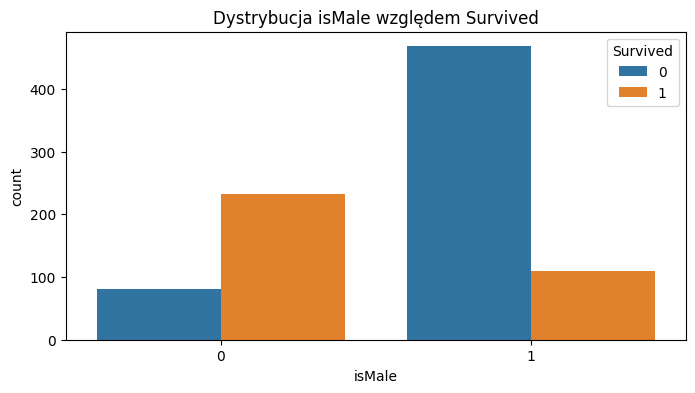

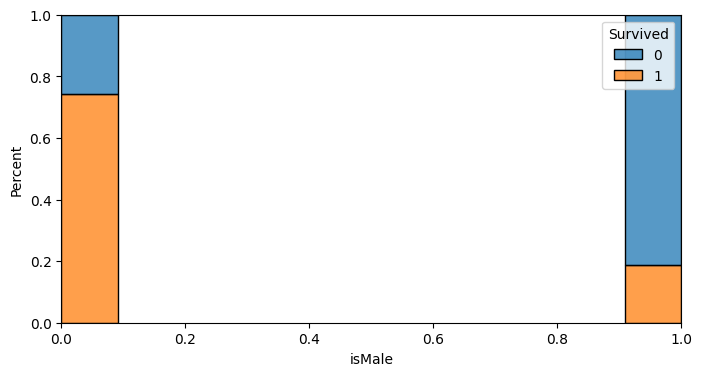

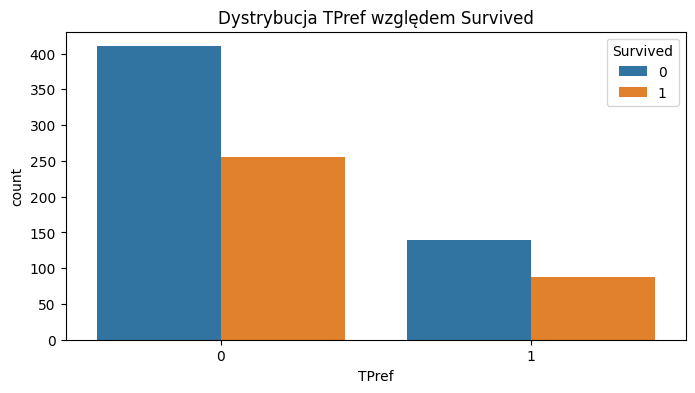

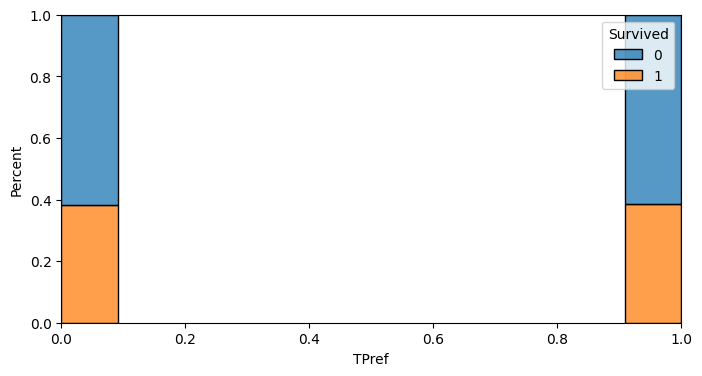

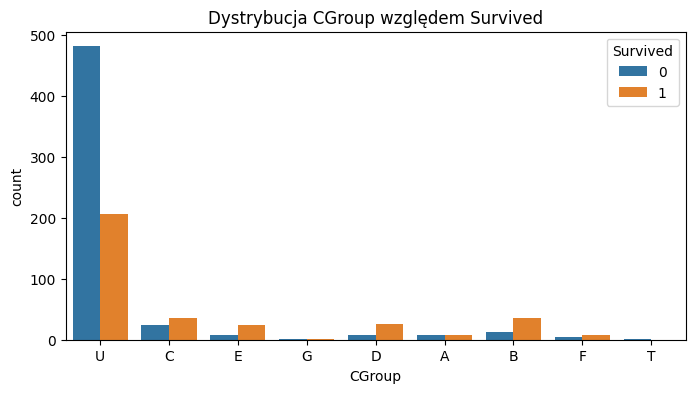

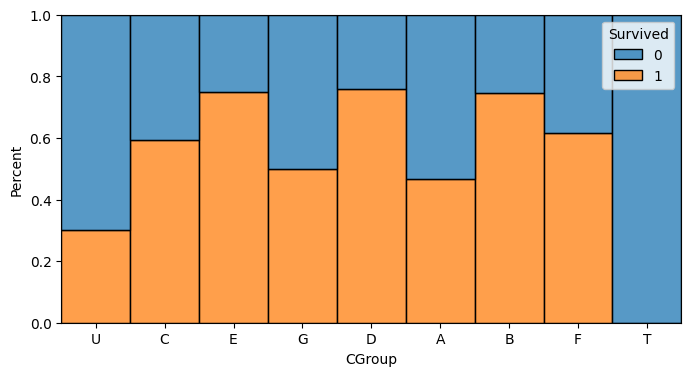

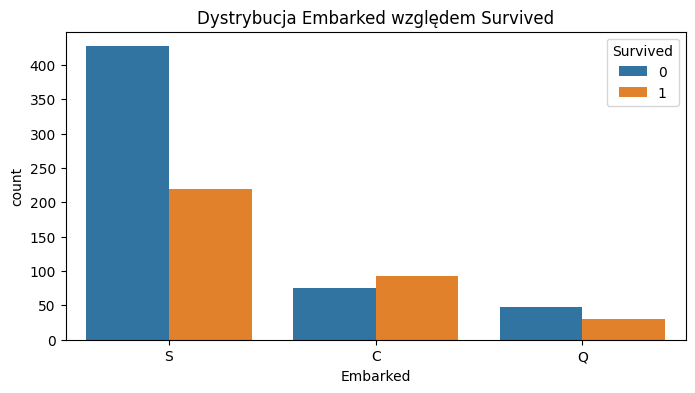

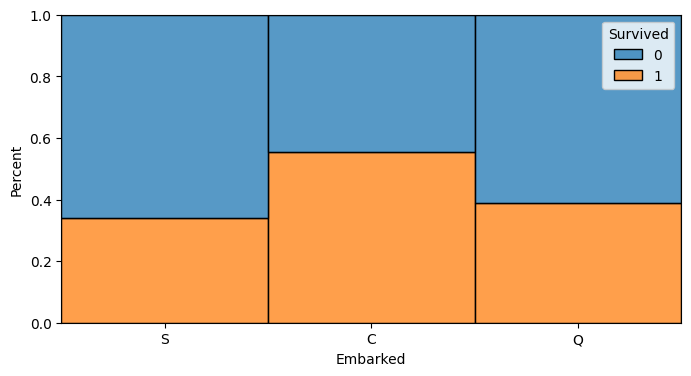

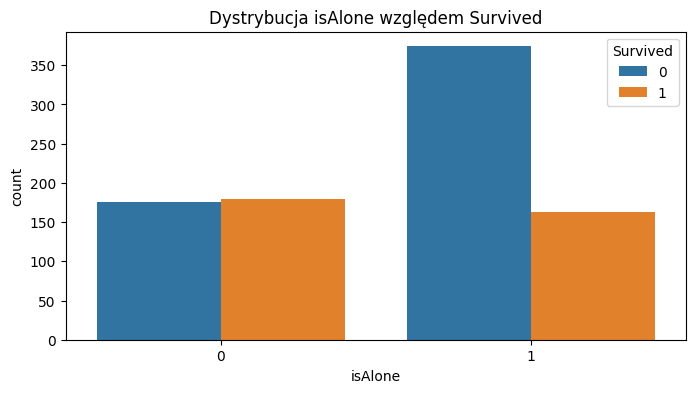

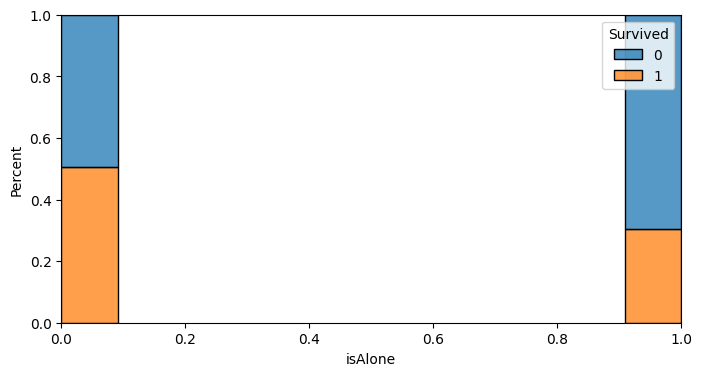

In [525]:
for col in categorical_columns:
  plot_categorical_data_count(titanic_df,col,target='Survived')
  plot_categorical_data_perc(titanic_df,col,target='Survived')
  print('\n')

Heatmapa macierzy korelacji oraz kodowanie danych

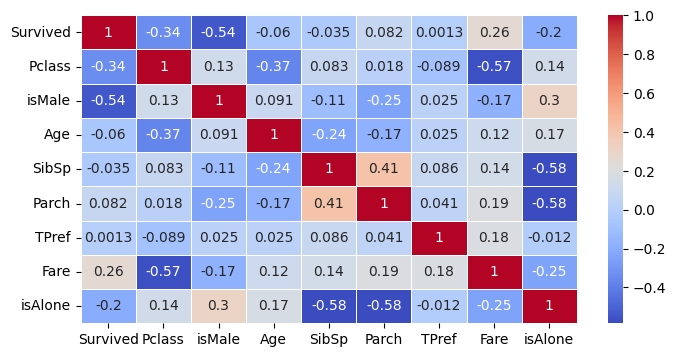

In [526]:
df = titanic_df.copy()
df =df.drop('CGroup',axis=1)
df =df.drop('Embarked',axis=1)
correlation_matrix = df.corr()
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.7)
plt.show()

**Wnioski**
Analizując wszystkie wykresy, oraz heatmape biorąc pod uwagę wartość Survived możemy dojść do wniosków:

* Młodsze osoby miały większe szanse na przeżycie niż starsze.

* Pasażerowie, którzy zapłacili więcej oraz byli w wyższej klasie, mieli wyższe szanse na przeżycie niż pozostali.

* Kobiety miały znacznie większe szanse na przeżycie niż mężczyźni.

* Osoby z mniejszymi rodzinami miały większe szanse na przeżycie.

* Prefiks w bilecie nie miał wpływu na przeżywalność pasażerów.

* Osoby, których kabiny były znane, miały większą przeżywalność niż te, których kabiny nie były znane (z wyjątkiem pasażerów z kabin T).

* Najmniejsze szanse na przeżycie mieli pasażerowie, którzy odpłynęli z portu C.

* Osoby, które nie podróżowały samotnie, miały większe szanse na przeżycie.

Używając heatmapy dodatkowo można zauważyć, że płeć, klasa oraz powiązana z nią ceną były najbardziej wpływowymi wartościami wpływającymi na przeżywalność.


**Wartości odstające**

In [527]:
def get_outliers(df,column,threshold):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3-Q1
  lower_bound = Q1 - threshold*IQR
  upper_bound = Q3 + threshold*IQR

  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
  return outliers

for column in numerical_columns:
  outliers = get_outliers(titanic_df,column=column,threshold=1.5)
  outliers_extreme = get_outliers(titanic_df,column=column,threshold=3.0)
  print(f"Dla {column} znaleziono {len(outliers)} outlierów oraz {len(outliers_extreme)} ekstremalnych outlierów")

Dla Age znaleziono 34 outlierów oraz 1 ekstremalnych outlierów
Dla Fare znaleziono 127 outlierów oraz 57 ekstremalnych outlierów
Dla SibSp znaleziono 46 outlierów oraz 12 ekstremalnych outlierów
Dla Parch znaleziono 213 outlierów oraz 213 ekstremalnych outlierów


Finalne kodowanie danych dzieląc kolumny i zamieniając wartości na logiczne

In [528]:
df = pd.get_dummies(titanic_df, columns=['Embarked', 'CGroup'], prefix=['Embarked', 'CGroup'])